# Statistical Learning Final Project

## Analysis of Tweets

### Kristyna Dolezalova,  Ufuk Caliskan & Efe Atikkan 

In [1]:
import tweepy
import csv
import pandas as pd
import  numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import  CountVectorizer
import re
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import json
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(123)

In this project, tweets from 4 political leaders of Turkey are analyzed and classifed. In order to gather the tweets, Twitter API is used(Only text part of the tweets are gathereed- hashtags and pictures are not included) . Then gathered tweets are cleaned from links and punctuations. Moreover Retweets are also ignored.
In order for classification algorithms (and any other statistical learning algorithm) to work, the pure texts need to be transformed to vectors/features. For this purpose following methods are used:
- Term Frequency-Inverse Document Frequency (TF-idf)
- Word Counts
- Tf - idf with Normalized Entropy Boosting
- Word2vec

After each of these preprocessing methods following classification methods are applied:
- Logistic regression
- Naive Bayes
- Support Vector Classifier
- Random Forest

The accuracy scores of each method combination is saved and compared. 
After the classifications the important features(words) are displayed for the highest preprocessing- classification combination for each candidate. The tweets are visualized in low dimension(2-3) using PCA and LDA. Finally the important features are visualized using Word2vec and PCA.

In [110]:
#The accuracy table for each preprocessing and classification method combination 
scores_df=pd.DataFrame(columns=['LR','NB','SVC','RF'],index=['Count','Tf-idf','Tf-idf_Reg','W2V'])
scores_df

,LR,NB,SVC,RF
Count,NaN,NaN,NaN,NaN
Tf-idf,NaN,NaN,NaN,NaN
Tf-idf_Reg,NaN,NaN,NaN,NaN
W2V,NaN,NaN,NaN,NaN


Through this notebook, the  commented cells do not need to be runned. The necessary data can be read directly from the given documents in the folder. 

In [3]:
# #Keys to use twitter api
# consumer_key = "ywbirhiIcQvIGZJgXQK63dwM2"
# consumer_secret = "fvpVG5wKpAgLLksBj4olnDadvnDIkw7GADw0yZD6xZKPNK8YdN"
# access_key = "876164561770041344-TzMYNEyCDvO2EZqjm16fORHHeHQtJer"
# access_secret = "Dskp88465N4wsLbQwlYb1zVvaqjSJWxXXYRl9ZZjHZZBP"

In [19]:
# #This part is taken from https://gist.github.com/freimanas/39f3ad9a5f0249c0dc64 . 
# # The user : freimanas

# import tweepy
# import csv
# import sys
# from urllib.request import urlopen

# def redirect(url):
#     page = urlopen(url)
#     return page.geturl()

# def get_all_tweets(screen_name):
#         auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
#         auth.set_access_token(access_key, access_secret)
#         api = tweepy.API(auth)
#         alltweets = []
#         new_tweets = api.user_timeline(screen_name = screen_name,count=1, tweet_mode='extended')
#         alltweets.extend(new_tweets)
#         oldest = alltweets[-1].id 
#         while len(new_tweets) > 0:
                
#                 new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest, tweet_mode='extended')
#                 alltweets.extend(new_tweets)
#                 oldest = alltweets[-1].id - 1
#         outtweets = [] 
#         for tweet in alltweets:
#                 outtweets.append([tweet.id_str, tweet.created_at, tweet.full_text, tweet.entities['hashtags']])
#         return(outtweets)
#         #write the csv  
#         with open('%s_tweets.csv' % screen_name, 'w') as f:
#                 writer = csv.writer(f)
#                 writer.writerow(["id","created_at","text","hashtags", "media_url"])
#                 writer.writerows(outtweets)
#         pass

In [4]:
# aa=get_all_tweets('RT_Erdogan')
# with open('%s_tweets.csv' % 'rte', 'w',encoding='utf-8') as f:
#                 writer = csv.writer(f)
#                 writer.writerows(aa)

# data_erd=pd.read_csv('rte_tweets.csv',header=None,names=['no','date','text','tag'])

In [5]:
# #ince tweets
# aa=get_all_tweets('vekilince')
# with open('%s_tweets.csv' % 'ince', 'w',encoding='utf-8') as f:
#                 writer = csv.writer(f)
#                 #writer.writerow(["id","created_at","text","hashtags", "media_url"])
#                 writer.writerows(aa)
                
# data_inc=pd.read_csv('ince_tweets.csv',header=None,names=['no','date','text','tag'])

In [6]:
# #demirtas
# #some things are with english keyboard,, take a look
# oo=get_all_tweets('hdpdemirtas')
# with open('%s_tweets.csv' % 'demirtas', 'w',encoding='utf-8') as f:
#                 writer = csv.writer(f)
#                 #writer.writerow(["id","created_at","text","hashtags", "media_url"])
#                 writer.writerows(oo)
                
# data_demirtas=pd.read_csv('demirtas_tweets.csv',header=None,names=['no','date','text','tag'])

In [7]:
# oo=get_all_tweets('meral_aksener')
# with open('%s_tweets.csv' % 'aksener', 'w',encoding='utf-8') as f:
#                 writer = csv.writer(f)
                
#                 writer.writerows(oo)
                
# #data_demirtas=pd.read_csv('demirtas_tweets.csv',header=None,names=['no','date','text','tag'])

## Data processing

In [3]:
# data_erd=pd.read_csv('rte_tweets.csv',header=None,names=['no','date','text','tag'])
# data_inc=pd.read_csv('ince_tweets.csv',header=None,names=['no','date','text','tag'])
# data_demirtas=pd.read_csv('demirtas_tweets.csv',header=None,names=['no','date','text','tag'])
# data_aksener=pd.read_csv('aksener_tweets.csv',header=None,names=['no','date','text','tag'])

# data_inc['cand']='ince'
# data_erd['cand']='erdogan'
# data_demirtas['cand']='demirtas'
# data_aksener['cand']='aksener'
# data=pd.concat([data_inc,data_erd,data_demirtas,data_aksener])
# data = data.sample(frac=1).reset_index(drop=True)
# data=data[['text','cand']]

In [4]:
# #'zemberek' library is loaded for stemming and word correction 
# import jpype
# jpype.startJVM(jpype.get_default_jvm_path(),
#          "-Djava.class.path=\\Users\\atief\\Desktop\\efe\\master\\derslerr\\2nd semester\\statlearning\\proje\\zembo\\eski\\zemberek-tum-2.0.jar", "-ea")
# Tr = jpype.JClass("net.zemberek.tr.yapi.TurkiyeTurkcesi")
# tr = Tr()
# Zemberek = jpype.JClass("net.zemberek.erisim.Zemberek")
# zemberek = Zemberek(tr)

In [5]:
# def cleaner(s):
#     a=re.sub('#\S*','',s)
#     a=re.sub('https\S*','',a)
#     a=re.sub('Teşekkürler\s\S*','',a,flags=re.IGNORECASE)
#     a = re.sub(r'[^\w\s]','',a)
    
#     a=a.strip()
#     if (a=='') or ('RT ' in s) or ('@' in s):
#         #print(s)
#         return np.NaN
#     else:
#         ll=[]
#         c=0
#         for w in a.split():
#             try:
#                 yanit = zemberek.kelimeCozumle(w)[0].kok().icerik()
#             except:
#                 try:
#                     yanit = zemberek.asciiCozumle(w)[0].kok().icerik()
#                 except:
#                     c=c+1
#                     yanit=w
#             ll.append(yanit)
#         a=' '.join(ll)
#         if c>=len(ll)*0.51:
#             #print(a)
            
#             return(np.NaN)
#         else:
#             return(a)

In [6]:
# data['text']=data['text'].apply(cleaner)
# data=data.dropna().reset_index(drop=True)



In [7]:
#data.to_csv('data.csv')

In [8]:
data=pd.read_csv('data.csv',index_col=0)

In [9]:
x=data.text
y=data.cand
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3,random_state=1)

In [5]:
print('x_train shape: '+ str(x_train.shape))
print('y_train shape: '+ str(y_train.shape))
print('x_test shape: '+ str(x_test.shape))
print('y_test shape: '+ str(y_test.shape))

x_train shape: (5838,)
y_train shape: (5838,)
x_test shape: (2502,)
y_test shape: (2502,)


In [68]:
# stop_words=set(stopwords.words('turkish'))
# stop_words.add('deyiz')
# stop_words=[cleaner(w) for w in stop_words]

In [70]:
# with open('stop_words.txt', 'w',encoding='utf-8') as filehandle:  
#     for listitem in stop_words:
#         filehandle.write('%s\n' % listitem)

In [10]:
stop_words = []
with open('stop_words.txt', 'r', encoding='utf-8') as filehandle:  
    for line in filehandle:
        currentPlace = line[:-1]
        stop_words.append(currentPlace)

In [288]:
x_train.head()

0                   biz bağır bas kardeş allah razı ol
1    8 kardeş de sat yol bırak kamu görev hayli hay...
2    bugün kadar nice badire üste gel başar türkiye...
3    bugün akşam CNN TÜRKde saat de Türkiyenin günd...
4    peygamber ocak türk ordu ve kahraman Mehmetimi...
Name: text, dtype: object

At this point, we have pure texts from tweets and we are ready to apply preprocessing and classification methods.
For the optimal parameter selection for each method, grid search is applied with cross-validation. After this, using the optimal hyper-parameters, training and prediction is done. (Grid search parts are commented out to save time. The given parameters inside the methods are the optimal ones and ready to be used)
The hyper-parameters we tried through grid search are: 
- n_gram option: [(1,2),(1,3)(1,4)] : For tf-idf and count vector creation, how each token is selected. 
        example: (1,2)= Seperate the text to 1 word and 2 words tokens. 
                 (1,3)= Sepearete the  text to 1 word, 2 words and  3words tokens. 
- Max_feature option: Applies to tf-idf and word count vectorizatiobs.
                      Number of features(words) are to consider. (They are ranked by term-frequency)
- C : The regularization parameter of logistic regression and SVC.
- N_estimators : Number of trees to consider in the random forest. 
     

# TF-IDF Vec

## Tf-idf + Logistic Reg.

In [235]:
# pipe=Pipeline([
#     ('tfidf_vectorizer',TfidfVectorizer(stop_words=ss)),
#     ('lrclassifier',LogisticRegression())
# ])
# n_gram_options=[(1,2),(1,3),(1,4)]
# max_feature_options=[1500,2500,5000,10000,20000]
# Cs=[0.5,1,2,5,10]
# params={'tfidf_vectorizer__ngram_range':n_gram_options,
#         'tfidf_vectorizer__max_features':max_feature_options,
#         'lrclassifier__C':Cs}

In [236]:
# gridsearch = GridSearchCV(pipe, params, verbose=1,return_train_score=True,n_jobs=3,cv=3,error_score=0).fit(x_train, y_train)

Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   21.7s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  1.5min
[Parallel(n_jobs=3)]: Done 225 out of 225 | elapsed:  1.7min finished


In [237]:
# gridsearch.best_params_

{'lrclassifier__C': 10,
 'tfidf_vectorizer__max_features': 20000,
 'tfidf_vectorizer__ngram_range': (1, 3)}

In [255]:
tt=TfidfVectorizer(stop_words=stop_words,ngram_range=(1,3),max_features=10000)
tt.fit(x_train)
x_train_idf=tt.transform(x_train)
x_test_idf=tt.transform(x_test)

In [256]:
lr=LogisticRegression(penalty='l2',C=10)
lr.fit(x_train_idf,y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [257]:
preds_train=lr.predict(x_train_idf)
accuracy_score(y_pred=preds_train,y_true=y_train)

0.99263446385748544

In [258]:
preds_test=lr.predict(x_test_idf)
accuracy_score(y_pred=preds_test,y_true=y_test)

0.74020783373301358

In [259]:
scores_df['LR']['Tf-idf']=accuracy_score(y_pred=preds_test,y_true=y_test)

In [261]:
confusion_matrix(y_pred=preds_test,y_true=y_test)

array([[542,  29,  78,  83],
       [ 42, 221,  39,  50],
       [ 68,  31, 588,  45],
       [ 74,  34,  77, 501]])

In [269]:
bas={}
for b in range(0,4):
    mydict = {}
    for i in range(0, len(lr.coef_[b])):
        if lr.coef_[b][i]>4.1:
            myc = lr.coef_[b][i]
            for word,key in tt.vocabulary_.items():
                if key == i:
                    mydict[word] = myc
    bas[b]=mydict

## Subsection - The analysis of regularization parameter C 

Before continuing with other classification methods, we thought it would be better to have small part about the regularization parameter C that is used in logistic regression and SVM. Although it is presented as they have the same parameter in sklearn, in theory, logistic regression has regularization parameter lambda(thats is associated with L1 or L2 regularization) and SVC has parameter C which acts like 1/lambda. In SVC the C parameter defines how much to allow slack variables (wrong classification).

In this section we examined the effect of C parameter on Logistic Regression for train and test set for various max_feature options for tf-idf.


In [119]:
pipe_graph=Pipeline([
    ('tfidf_vectorizer',TfidfVectorizer(stop_words=stop_words,ngram_range=(1,3))),
    ('lrclassifier',LogisticRegression())
])

max_feature_options=[1500,2500,5000,10000,20000]
Cs=[0.5,1,10,30,50,100,150]
params={'tfidf_vectorizer__max_features':max_feature_options,
        'lrclassifier__C':Cs}

In [120]:
gridsearch_graph = GridSearchCV(pipe_graph, params, verbose=1,return_train_score=True,n_jobs=3,cv=3,error_score=0).fit(x_train, y_train)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   29.8s
[Parallel(n_jobs=3)]: Done 105 out of 105 | elapsed:   59.4s finished


In [121]:
y = gridsearch_graph.cv_results_["mean_test_score"].tolist()
x = []
z = []
for i in gridsearch_graph.cv_results_['params']:
    x.append(i['tfidf_vectorizer__max_features'])
    z.append(i['lrclassifier__C'])

In [122]:
df2 = pd.DataFrame()
df2["max_feat"] = x
df2["score"] = y
df2["C"] = z

In [123]:
def myplot(sep_param, xcol, ycol, xlab, ylab, title):    
    fig=plt.figure(figsize=(20,10))
    for i in set(df2[sep_param].tolist()):
        plt.plot(df2[df2[sep_param]==i][xcol], df2[df2[sep_param]==i][ycol], marker = "o")
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    plt.title(title, fontsize=30)
    plt.legend(set(df2[sep_param].tolist()), ncol=1, loc='lower right', prop = {"size": 20});
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #plt.savefig('regultrain.jpg')
    plt.show()

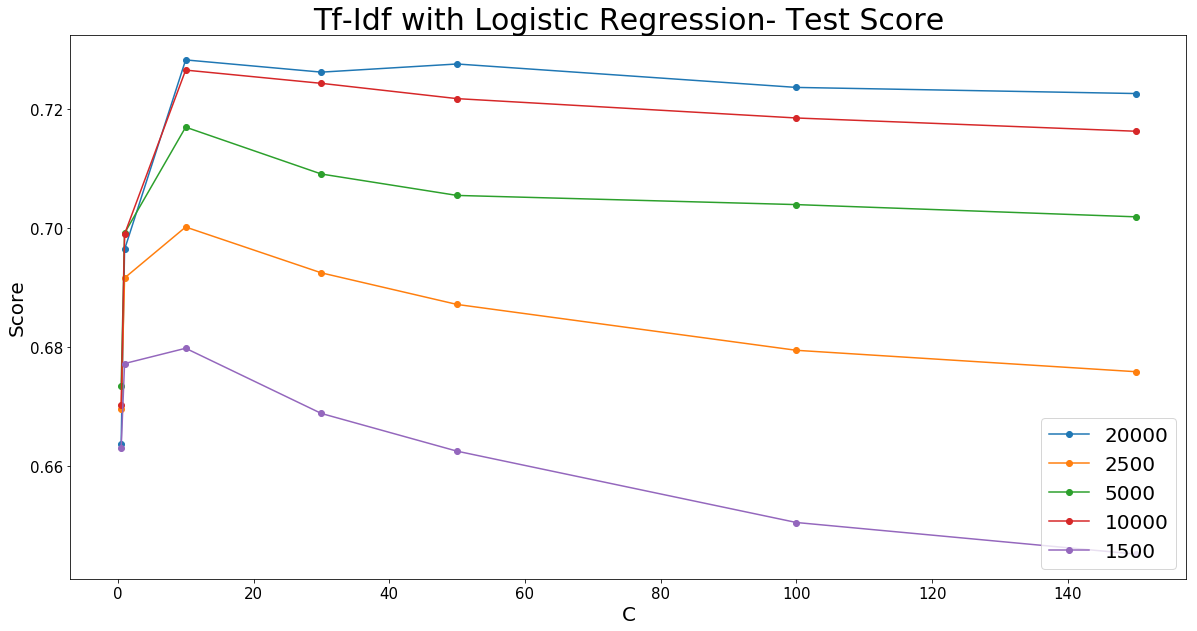

In [124]:
myplot( "max_feat","C", "score", "C","Score", "Tf-Idf with Logistic Regression- Test Score")

In [125]:
y = gridsearch_graph.cv_results_["mean_train_score"].tolist()
x = []
z = []
for i in gridsearch_graph.cv_results_['params']:
    x.append(i['tfidf_vectorizer__max_features'])
    z.append(i['lrclassifier__C'])

df2 = pd.DataFrame()
df2["max_feat"] = x
df2["score"] = y
df2["C"] = z

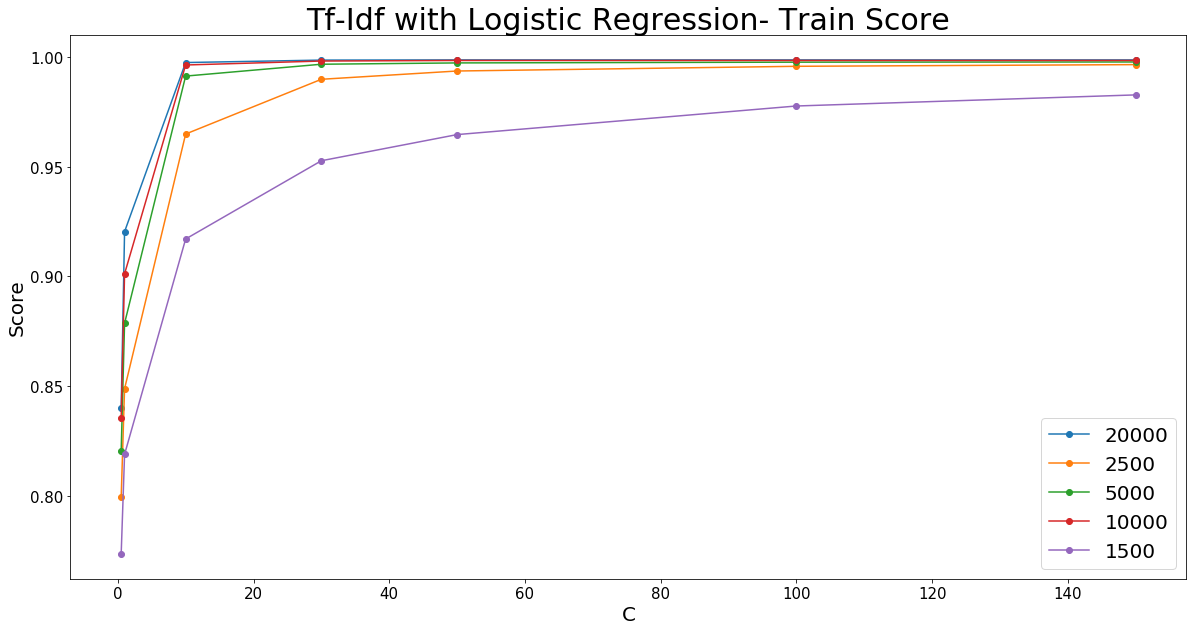

In [126]:

myplot("max_feat","C", "score", "C","Score", "Tf-Idf with Logistic Regression- Train Score")

As we can see in these two plot, the training accuracy goes to 1 as C gets larger (as regularization gets smaller) where as test accuracy drops after some value of  C. We can say that for the lower values  of C we have underfitting whereas for the larger values  of C we observe overfitting.

## Tf-idf + SVC

In [127]:
# pipe4=Pipeline([
#     ('tfidf_vectorizer',TfidfVectorizer(stop_words=ss)),
#     ('classifier',SVC(kernel='linear'))
# ])
# n_gram_options=[(1,2),(1,3),(1,4)]
# max_feature_options=[2500,5000,10000,20000]
# c_options=[0.1,0.5,1,5,10]
# params={'tfidf_vectorizer__ngram_range':n_gram_options,
#         'tfidf_vectorizer__max_features':max_feature_options,
#         'classifier__C':c_options}

In [128]:
#gridsearch4 = GridSearchCV(pipe4, params, verbose=1,return_train_score=True,n_jobs=3,cv=3,error_score=0).fit(x_train, y_train)

In [129]:
#gridsearch4.best_params_

In [130]:
tt4=TfidfVectorizer(stop_words=stop_words,ngram_range=(1,2),max_features=20000)
tt4.fit(x_train)
x_train_idf=tt4.transform(x_train)
x_test_idf=tt4.transform(x_test)

svc=SVC(kernel='linear',C=1)
svc.fit(x_train_idf,y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [131]:
preds_train=svc.predict(x_train_idf)
accuracy_score(y_pred=preds_train,y_true=y_train)

0.97344981157930799

In [132]:
preds_test=svc.predict(x_test_idf)
accuracy_score(y_pred=preds_test,y_true=y_test)

0.74020783373301358

In [133]:
scores_df['SVC']['Tf-idf']=accuracy_score(y_pred=preds_test,y_true=y_test)

In [134]:
scores_df

,LR,NB,SVC,RF
Count,NaN,NaN,NaN,NaN
Tf-idf,0.740208,NaN,0.740208,NaN
Tf-idf_Reg,NaN,NaN,NaN,NaN
W2V,NaN,NaN,NaN,NaN


## Tfidf + Naive Bayes

In [135]:
# pipe5=Pipeline([
#     ('tfidf_vectorizer',TfidfVectorizer(stop_words=ss)),
#     ('classifier',MultinomialNB())
# ])
# n_gram_options=[(1,2),(1,3),(1,4)]
# max_feature_options=[2500,5000,10000,20000]

# params={'tfidf_vectorizer__ngram_range':n_gram_options,
#         'tfidf_vectorizer__max_features':max_feature_options}

In [136]:
#gridsearch5 = GridSearchCV(pipe5, params, verbose=1,return_train_score=True,n_jobs=3,cv=5,error_score=0).fit(x_train, y_train)

In [137]:
#gridsearch5.best_params_

In [138]:
tt5=TfidfVectorizer(stop_words=stop_words,ngram_range=(1,3),max_features=2500)
tt5.fit(x_train)
x_train_idf=tt5.transform(x_train)
x_test_idf=tt5.transform(x_test)

nb=MultinomialNB()
nb.fit(x_train_idf,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [139]:
preds_train=nb.predict(x_train_idf.toarray())
accuracy_score(y_pred=preds_train,y_true=y_train)

0.78108941418293931

In [140]:
preds_test=nb.predict(x_test_idf.toarray())
accuracy_score(y_pred=preds_test,y_true=y_test)

0.6770583533173461

In [141]:
scores_df['NB']['Tf-idf']=accuracy_score(y_pred=preds_test,y_true=y_test)

In [142]:
scores_df

,LR,NB,SVC,RF
Count,NaN,NaN,NaN,NaN
Tf-idf,0.740208,0.677058,0.740208,NaN
Tf-idf_Reg,NaN,NaN,NaN,NaN
W2V,NaN,NaN,NaN,NaN


## Tfidf + RF

In [143]:
# pipe8=Pipeline([
#     ('tfidf_vectorizer',TfidfVectorizer(stop_words=ss,ngram_range=(1,3),max_features=5000)),
#     ('classifier',RandomForestClassifier())
# ])

# n_estimators =[20,100]
# min_samples_leafs=[10,50]

# params={'classifier__n_estimators':n_estimators,
#         'classifier__min_samples_leaf':min_samples_leafs}

In [144]:
#gridsearch8=GridSearchCV(pipe8,param_grid=params,cv=3,n_jobs=3,verbose=1).fit(x_train, y_train)

In [145]:
tt8=TfidfVectorizer(stop_words=stop_words,ngram_range=(1,3),max_features=5000)
tt8.fit(x_train)
x_train_idf=tt8.transform(x_train)
x_test_idf=tt8.transform(x_test)

rf=RandomForestClassifier(n_estimators=100,min_samples_leaf=10)
rf.fit(x_train_idf,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [146]:
preds_train=rf.predict(x_train_idf)
accuracy_score(y_pred=preds_train,y_true=y_train)

0.66940733127783492

In [147]:
preds_test=rf.predict(x_test_idf)
accuracy_score(y_pred=preds_test,y_true=y_test)

0.59152677857713831

In [148]:
scores_df['RF']['Tf-idf']=accuracy_score(y_pred=preds_test,y_true=y_test)

# Count Vec

## Count Vec + Logistic Reg.

In [149]:
# pipe2=Pipeline([
#     ('count_vectorizer',CountVectorizer(stop_words=ss)),
#     ('lrclassifier',LogisticRegression())
# ])
# n_gram_options=[(1,2),(1,3),(1,4)]
# max_feature_options=[1500,2500,5000,10000,20000]
# cs=[0.5,1,2,5,10]
# params={'count_vectorizer__ngram_range':n_gram_options,
#         'count_vectorizer__max_features':max_feature_options,
#         'lrclassifier__C':cs
#         }

In [150]:
#gridsearch2 = GridSearchCV(pipe2, params, verbose=1,return_train_score=True,n_jobs=3,cv=5,error_score=0).fit(x_train, y_train)

In [151]:
#gridsearch2.best_params_

In [152]:
tt2=CountVectorizer(stop_words=stop_words,ngram_range=(1,2),max_features=10000)
tt2.fit(x_train)
x_train_count=tt2.transform(x_train)
x_test_count=tt2.transform(x_test)
lr=LogisticRegression(penalty='l2',C=2)
lr.fit(x_train_count,y_train)

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [153]:
preds_train=lr.predict(x_train_count)
accuracy_score(y_pred=preds_train,y_true=y_train)

0.99109284001370335

In [154]:
preds_test=lr.predict(x_test_count)
accuracy_score(y_pred=preds_test,y_true=y_test)

0.72781774580335734

In [155]:
scores_df['LR']['Count']=accuracy_score(y_pred=preds_test,y_true=y_test)

In [156]:
scores_df

,LR,NB,SVC,RF
Count,0.727818,NaN,NaN,NaN
Tf-idf,0.740208,0.677058,0.740208,0.591527
Tf-idf_Reg,NaN,NaN,NaN,NaN
W2V,NaN,NaN,NaN,NaN


In [157]:
print(classification_report(y_pred=preds_test,y_true=y_test))

             precision    recall  f1-score   support

    aksener       0.74      0.72      0.73       732
   demirtas       0.67      0.61      0.64       352
    erdogan       0.76      0.78      0.77       732
       ince       0.71      0.74      0.73       686

avg / total       0.73      0.73      0.73      2502



In [158]:
confusion_matrix(y_pred=preds_test,y_true=y_test)

array([[528,  33,  76,  95],
       [ 40, 214,  41,  57],
       [ 75,  35, 568,  54],
       [ 73,  39,  63, 511]])

## Count Vec + SVC

In [159]:
# pipe3=Pipeline([
#     ('count_vectorizer',CountVectorizer(stop_words=ss)),
#     ('classifier',SVC(kernel='linear'))
# ])
# n_gram_options=[(1,2),(1,3),(1,4)]
# max_feature_options=[2500,5000,10000,20000]
# c_options=[0.1,0.5,1,5,10]
# params={'count_vectorizer__ngram_range':n_gram_options,
#         'count_vectorizer__max_features':max_feature_options,
#         'classifier__C':c_options}

In [160]:
#gridsearch3 = GridSearchCV(pipe3, params, verbose=1,return_train_score=True,n_jobs=3,cv=3,error_score=0).fit(x_train, y_train)

In [161]:
#gridsearch3.best_params_

In [162]:
tt3=CountVectorizer(stop_words=stop_words,ngram_range=(1,2),max_features=10000)
tt3.fit(x_train)
x_train_count=tt3.transform(x_train)
x_test_count=tt3.transform(x_test)

svc=SVC(kernel='linear',C=0.1)
svc.fit(x_train_count,y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [163]:
preds_train=svc.predict(x_train_count)
accuracy_score(y_pred=preds_train,y_true=y_train)

0.93747858855772526

In [164]:
preds_test=svc.predict(x_test_count)
accuracy_score(y_pred=preds_test,y_true=y_test)

0.71063149480415666

In [165]:
scores_df['SVC']['Count']=accuracy_score(y_pred=preds_test,y_true=y_test)

In [166]:
scores_df

,LR,NB,SVC,RF
Count,0.727818,NaN,0.710631,NaN
Tf-idf,0.740208,0.677058,0.740208,0.591527
Tf-idf_Reg,NaN,NaN,NaN,NaN
W2V,NaN,NaN,NaN,NaN


## Count Vec + Naive Bayes

In [167]:
# pipe6=Pipeline([
#     ('count_vectorizer',CountVectorizer(stop_words=ss)),
#     ('classifier',MultinomialNB())
# ])
# n_gram_options=[(1,2),(1,3),(1,4)]
# max_feature_options=[2500,5000,10000,20000]

# params={'count_vectorizer__ngram_range':n_gram_options,
#         'count_vectorizer__max_features':max_feature_options}

In [168]:
#gridsearch6 = GridSearchCV(pipe6, params, verbose=1,return_train_score=True,n_jobs=3,cv=5,error_score=0).fit(x_train, y_train)

In [169]:
#gridsearch6.best_params_

In [170]:
tt6=CountVectorizer(stop_words=stop_words,ngram_range=(1,2),max_features=10000)
tt6.fit(x_train)
x_train_count=tt6.transform(x_train)
x_test_count=tt6.transform(x_test)

nb2=MultinomialNB()
nb2.fit(x_train_count,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [171]:
preds_train=nb2.predict(x_train_count.toarray())
accuracy_score(y_pred=preds_train,y_true=y_train)

0.89105858170606367

In [172]:
preds_test=nb2.predict(x_test_count.toarray())
accuracy_score(y_pred=preds_test,y_true=y_test)

0.73221422861710628

In [173]:
scores_df['NB']['Count']=accuracy_score(y_pred=preds_test,y_true=y_test)

In [174]:
scores_df

,LR,NB,SVC,RF
Count,0.727818,0.732214,0.710631,NaN
Tf-idf,0.740208,0.677058,0.740208,0.591527
Tf-idf_Reg,NaN,NaN,NaN,NaN
W2V,NaN,NaN,NaN,NaN


## Count Vec. + RF

In [175]:
# pipe9=Pipeline([
#     ('count_vectorizer',CountVectorizer(stop_words=ss)),
#     ('classifier',RandomForestClassifier())
# ])

# n_gram_options=[(1,2),(1,3)]
# max_feature_options=[2500,5000,10000]
# n_estimators =[20,100]
# min_samples_leafs=[10,50]

# params={'count_vectorizer__ngram_range':n_gram_options,
#         'count_vectorizer__max_features':max_feature_options,
#         'classifier__n_estimators':n_estimators,
#         'classifier__min_samples_leaf':min_samples_leafs}

In [176]:
#gridsearch9=GridSearchCV(pipe9,param_grid=params,cv=3,n_jobs=3,verbose=1).fit(x_train, y_train)

In [21]:
#gridsearch9.best_params_

{'classifier__min_samples_leaf': 10,
 'classifier__n_estimators': 100,
 'count_vectorizer__max_features': 5000,
 'count_vectorizer__ngram_range': (1, 3)}

In [177]:
tt9=CountVectorizer(stop_words=stop_words,ngram_range=(1,3),max_features=5000)
tt9.fit(x_train)
x_train_idf=tt9.transform(x_train)
x_test_idf=tt9.transform(x_test)

rf=RandomForestClassifier(n_estimators=100,min_samples_leaf=10)
rf.fit(x_train_idf,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [178]:
preds_train=rf.predict(x_train_idf)
accuracy_score(y_pred=preds_train,y_true=y_train)

0.62675573826652964

In [179]:
preds_test=rf.predict(x_test_idf)
accuracy_score(y_pred=preds_test,y_true=y_test)

0.57913669064748197

In [180]:
scores_df['RF']['Count']=accuracy_score(y_pred=preds_test,y_true=y_test)

In [181]:
scores_df

,LR,NB,SVC,RF
Count,0.727818,0.732214,0.710631,0.579137
Tf-idf,0.740208,0.677058,0.740208,0.591527
Tf-idf_Reg,NaN,NaN,NaN,NaN
W2V,NaN,NaN,NaN,NaN


# Tf-idf class normalized

Usual Tf-idf vectorization of the texts, does not consider the classes that the text belongs to. For this reason, an improved version of tf-idf where this issue is handled can be implemented.

In the paper, 'Samujjwal Ghosh and Maunendra Sankar Desarkar. 2018. Class Specific TF-IDF Boosting for Short-text Classification: Application to Short-texts Generated During Disasters' , a method is explained where the tf-idf score of  each word is also multipled with a normalized entropy. 

The entropy of each word is calculated using the following formula:

$ H(t^i) =  - \sum_{c=1}^{m} \frac{tc_c^i}{tc^i} * log_2(\frac{tc_c^i}{tc^i})$ 

and normalized entropy is calculated by:

$NE(t^i)=\frac{H_{max}-H(t^i)}{H_{max}}$

where $tc_i^c$ denotes the count of term $t_i$ in class c and $tc^i$ denotes the count of the term for all classes. By this method the distribution of each word among each class is taken into account and more reliable results can be obtained. 

link to paper: https://www.cse.iitk.ac.in/users/kripa/smerp2018/samujjwalGhosh.pdf


In [182]:
t_try=CountVectorizer(stop_words=stop_words)
t_try.fit(x_train)
x_train_try=t_try.transform(x_train)
x_test_try=t_try.transform(x_test)

In [183]:
new_df=pd.DataFrame(x_train_try.toarray())
new_df['cand']=y_train.reset_index(drop=True)
cands=np.unique(y_test)

In [184]:
def entropy_calculator(idm): 
    #idm=t_try.vocabulary_[word]
    
    res=[]
    
    for c in cands:
        res.append(sum(new_df[new_df['cand']==c][idm]))
    #print('res:'+str(res))
    res_p=np.array(res)/sum(res)
    #print(['res_p:'+str(res_p)])
    val=0
    for i in range(3):
        if np.log2(res_p[i])!=-np.inf:
            val=val+res_p[i]*np.log2(res_p[i])
        
    return(-val)

In [185]:
#akes too much time
#entro_dict={x:entropy_calculator(y) for x,y in t_try.vocabulary_.items()}

In [186]:
# with open('entro_dict.txt','w') as outfile:
#     json.dump(entro_dict, outfile)

In [187]:
import json
with open('entro_dict.txt', 'r') as f:
        entro_dict = json.load(f)

In [188]:
def NE(word):
    entro=entro_dict[word]
    max_entro=max(entro_dict.values())
    res=(max_entro-entro)/max_entro
    return(res)

In [189]:
ne_dict={}
for word in entro_dict.keys():
    ne_dict[word]=NE(word) 

In [190]:
x_train_try=pd.DataFrame(x_train_try.toarray())

In [191]:
t_try2=TfidfVectorizer(stop_words=stop_words)
t_try2.fit(x_train)
x_train_try2=t_try2.transform(x_train)
x_test_try2=t_try2.transform(x_test)

In [192]:
x_train_try2=pd.DataFrame(x_train_try2.toarray())
x_test_try2=pd.DataFrame(x_test_try2.toarray())

In [193]:
#make  inverse of word-id map
id_word_map={v:k for k,v in t_try.vocabulary_.items()}

In [194]:
ne_array=np.array([ne_dict[id_word_map[i]] for i in range(x_test_try2.shape[1]) ])
x_train_try2=x_train_try2.mul(ne_array)
x_test_try2=x_test_try2.mul(ne_array)

## Tfidf++ + Logistic Reg.

In [140]:
# cs=[1,5,10,15,20,25,30]
# gridsearch7 = GridSearchCV(LogisticRegression(),param_grid={'C':cs}, verbose=1,return_train_score=True,n_jobs=3,cv=5,error_score=0).fit(x_train_tfidf_norm, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=3)]: Done  35 out of  35 | elapsed:   30.6s finished


In [141]:
#gridsearch7.best_params_

{'C': 30}

In [195]:
lr=LogisticRegression(penalty='l2',C=30)
lr.fit(x_train_try2,y_train)

LogisticRegression(C=30, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [196]:
preds_train=lr.predict(x_train_try2)
accuracy_score(y_pred=preds_train,y_true=y_train)

0.96077423775265502

In [197]:
preds_test=lr.predict(x_test_try2)
accuracy_score(y_pred=preds_test,y_true=y_test)

0.71342925659472423

In [198]:
scores_df['LR']['Tf-idf_Reg']=accuracy_score(y_pred=preds_test,y_true=y_test)

In [199]:
scores_df

,LR,NB,SVC,RF
Count,0.727818,0.732214,0.710631,0.579137
Tf-idf,0.740208,0.677058,0.740208,0.591527
Tf-idf_Reg,0.713429,NaN,NaN,NaN
W2V,NaN,NaN,NaN,NaN


## Tfidf++ + Naive Bayes

In [200]:
nb=MultinomialNB()
nb.fit(x_train_try2,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [201]:
preds_train=nb.predict(x_train_try2)
accuracy_score(y_pred=preds_train,y_true=y_train)

0.77149708804385064

In [202]:
preds_test=nb.predict(x_test_try2)
accuracy_score(y_pred=preds_test,y_true=y_test)

0.61111111111111116

In [203]:
scores_df['NB']['Tf-idf_Reg']=accuracy_score(y_pred=preds_test,y_true=y_test)

# TFidf++ + RF

In [92]:
# n_estimators =[20,100]
# min_samples_leafs=[10,50]
# gridsearch9=GridSearchCV(RandomForestClassifier(),param_grid={'n_estimators':n_estimators,'min_samples_leaf':min_samples_leafs},cv=3,n_jobs=3,verbose=1).fit(x_train_try2, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:   38.9s finished


In [93]:
# gridsearch9.best_params_

{'min_samples_leaf': 10, 'n_estimators': 100}

In [204]:
rf=RandomForestClassifier(n_estimators=100,min_samples_leaf=10)
rf.fit(x_train_try2,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [205]:
preds_train=rf.predict(x_train_try2)
accuracy_score(y_pred=preds_train,y_true=y_train)

0.66015758821514214

In [206]:
preds_test=rf.predict(x_test_try2)
accuracy_score(y_pred=preds_test,y_true=y_test)

0.58633093525179858

In [207]:
scores_df['RF']['Tf-idf_Reg']=accuracy_score(y_pred=preds_test,y_true=y_test)
scores_df

,LR,NB,SVC,RF
Count,0.727818,0.732214,0.710631,0.579137
Tf-idf,0.740208,0.677058,0.740208,0.591527
Tf-idf_Reg,0.713429,0.611111,NaN,0.586331
W2V,NaN,NaN,NaN,NaN


# word2vec

Word2Vec is a method to create a vector space for the words depending on their neighbors. Given a train set, it learns for every unique word in the train set the neighbors and creates with that information a vector in a vector space with a fixed length which is defined by a parameter. We use this method to create feature vectors for each unique words in our tweets. As a model we used a predefined model by … After the words are transformed to vectors for each tweet a new vector is created by taking average of already calculated word vectors. In the end, these feature vectors are used to train the classification algorithms.

In [208]:
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('trmodel', binary=True)

In [209]:
df_train = pd.DataFrame(columns=range(0,400),index=range(0,5065))

In [210]:
def changer(inn):
    inn=inn.split()
    sum_vector=np.zeros(word_vectors.vector_size)
    a=0
    for token in inn:
        try:
            sum_vector += word_vectors[token]
            a=a+1
        except:
            pass
    if a==0:
        sentence_vector=0
    else:
        sentence_vector = sum_vector / a
    return(sentence_vector)

In [211]:
x_train.reset_index(drop=True,inplace=True)

In [212]:
#takes too much time
# for r in range(x_train.shape[0]):
#     inn=x_train[r]
#     s_v=changer(inn)
#     df_train.loc[r]=s_v

In [213]:
#df_train.to_csv('w2vdf.csv')

In [214]:
# to read directly
df_train=pd.read_csv('w2vdf.csv',index_col=0)

In [215]:
x_train_word2vec=df_train

In [216]:
df_test = pd.DataFrame(columns=range(0,400),index=range(0,2171))
x_test.reset_index(drop=True,inplace=True)

In [217]:
for r in range(x_test.shape[0]):
    inn=x_test[r]
    s_v=changer(inn)
    df_test.loc[r]=s_v
x_test_word2vec=df_test

## Word2vec + Logistic Reg.

In [109]:
# C=[0.5,1,5]
# gridsearch9=GridSearchCV(LogisticRegression(),param_grid={'C':C},cv=3,n_jobs=3,verbose=1).fit(x_train_word2vec, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:   25.1s finished


In [110]:
#gridsearch9.best_params_

{'C': 0.5}

In [218]:
lr=LogisticRegression(penalty='l2',C=0.5)
lr.fit(x_train_word2vec,y_train)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [219]:
preds_train=lr.predict(x_train_word2vec)
accuracy_score(y_pred=preds_train,y_true=y_train)

0.68396711202466598

In [220]:
x_train_word2vec.shape

(5838, 400)

In [221]:
preds_test=lr.predict(x_test_word2vec)
accuracy_score(y_pred=preds_test,y_true=y_test)

0.59312549960031979

In [222]:
scores_df['LR']['W2V']=accuracy_score(y_pred=preds_test,y_true=y_test)

In [223]:
scores_df

,LR,NB,SVC,RF
Count,0.727818,0.732214,0.710631,0.579137
Tf-idf,0.740208,0.677058,0.740208,0.591527
Tf-idf_Reg,0.713429,0.611111,NaN,0.586331
W2V,0.593125,NaN,NaN,NaN


# word2vec + RF

In [151]:
# n_estimators =[20,100]
# min_samples_leafs=[10,50]
# gridsearch11=GridSearchCV(RandomForestClassifier(),param_grid={'n_estimators':n_estimators,'min_samples_leaf':min_samples_leafs},cv=3,n_jobs=3,verbose=1).fit(x_train_word2vec, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed:   16.8s finished


In [153]:
#gridsearch11.best_params_

{'min_samples_leaf': 10, 'n_estimators': 100}

In [224]:
rf=RandomForestClassifier(n_estimators=100,min_samples_leaf=10)
rf.fit(x_train_word2vec,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [225]:
preds_train=rf.predict(x_train_word2vec)
accuracy_score(y_pred=preds_train,y_true=y_train)

0.92617334703665644

In [226]:
preds_test=rf.predict(x_test_word2vec)
accuracy_score(y_pred=preds_test,y_true=y_test)

0.54236610711430855

In [227]:
scores_df['RF']['W2V']=accuracy_score(y_pred=preds_test,y_true=y_test)

In [228]:
scores_df

,LR,NB,SVC,RF
Count,0.727818,0.732214,0.710631,0.579137
Tf-idf,0.740208,0.677058,0.740208,0.591527
Tf-idf_Reg,0.713429,0.611111,NaN,0.586331
W2V,0.593125,NaN,NaN,0.542366


# Plots

In [229]:
scores_df=scores_df.apply(pd.to_numeric)

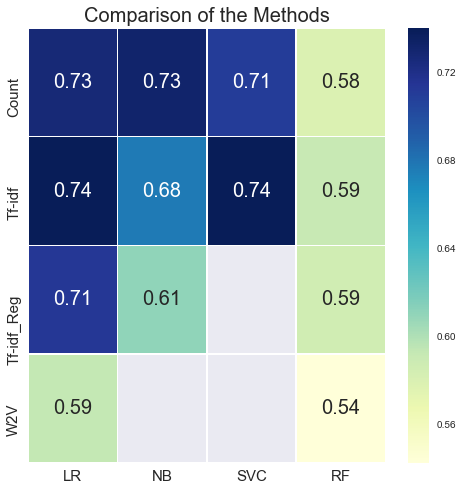

In [230]:
sns.set()
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(scores_df, annot=True, linewidths=.5, ax=ax, cmap="YlGnBu",annot_kws={"size": 20})
plt.title('Comparison of the Methods',fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('comparison_heat.jpg')
plt.show()

The accuracy score for each preprocessing and classification combination is visualized. For our dataset, Logistic regression with TF-idf vectorization is giving the best result however 'Count Vectorization' is also giving good results with logistic regression and naive bayes.
In general we were expecting regulerized tf-idf vectorization to beat ordinary tf-idf however the reesults were away from our expectation. Also another non- traditional method, Word2Vec, could not compete with tf-idf and word count vectorization methods. The one reason of it may be the usage of pretrained model for Word2Vec. Alternatively, it  may be not too successfull due to our dataset or in general short text data(tweets) in Turkish. 
Between the classification methods we can see tha Random Forest is the less successfull one which was something that was already knwon to be less precise compared to Logistic Regression, SVC and Naive Bayes. Again as expected Naive Bayes works good with word count vectorization but not as good with Tf-idf. 

C:\Users\atief\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


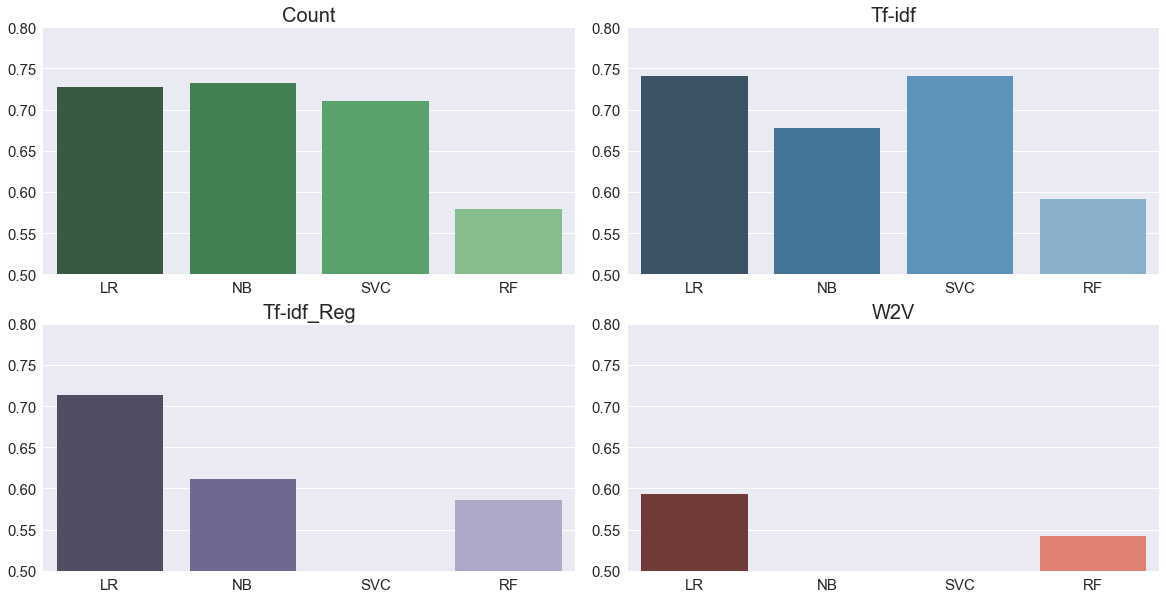

In [231]:
col = ["Greens_d","Blues_d","Purples_d","Reds_d"]
fig=plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.2, wspace=0.1)
k=0
for index, row in scores_df.iterrows():    
    plt.subplot(2, 2, (k+1))
    sns.barplot(data=scores_df.iloc[[k]], palette=col[k])
    plt.title(index, fontsize=20)
    plt.ylim(0.5, 0.8)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    k=k+1

plt.savefig('barplots.jpg')
plt.show()

# Word Cloud

The important words(features) chosen by the most successful method combination are  visualized as word cloud in this section for each candidate.(The results are translated to English.)

In [232]:
sorted_by_value = [sorted(bas[i].items(), key=lambda kv: kv[1],reverse=True) for i in range(0,4)]
sorted_by_value

bas_eng_0=['Mr./Ms.','iyi parti','ülkü?','welcome','woman','turkish','mhp','iyi','townsman','heaven','friday','ülküdaş?','patience','citizen','referandum','live','people']
bas_eng_1=['day','still','hi','peace','whole','massacre','citizens','water','newroz','everyone','arrested','little','akp','honour','freedom','unfortunately','goverment']
bas_eng_2=['Egypt','people','akp','mayor','world','city','ak','candidate','country','president cand.','turkeys','never','brother','turkey','service','chp','continue']
bas_eng_3=['fooled','at yalova','congressman','tomorrow','yalova','melih','constitution','coup','public','teacher','explain','president','tayyip','generous','greetings','hometown','republic']

In [233]:
vals0=[i[1] for i in sorted_by_value[0][:17]]
bas_eng_0=dict(zip(bas_eng_0,vals0))

vals1=[i[1] for i in sorted_by_value[1][:17]]
bas_eng_1=dict(zip(bas_eng_1,vals1))

vals2=[i[1] for i in sorted_by_value[2][:17]]
bas_eng_2=dict(zip(bas_eng_2,vals2))

vals3=[i[1] for i in sorted_by_value[3][:17]]
bas_eng_3=dict(zip(bas_eng_3,vals3))

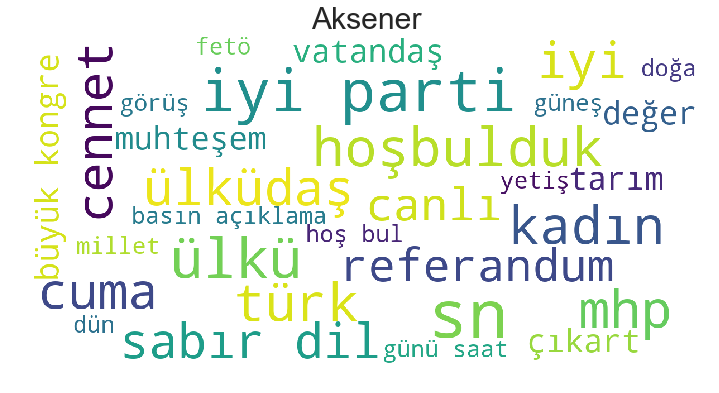

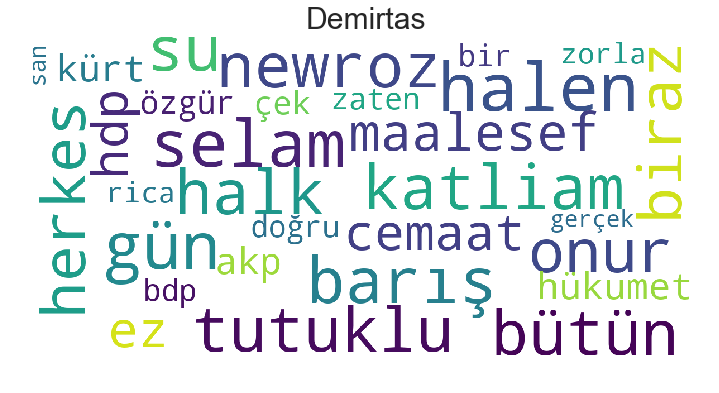

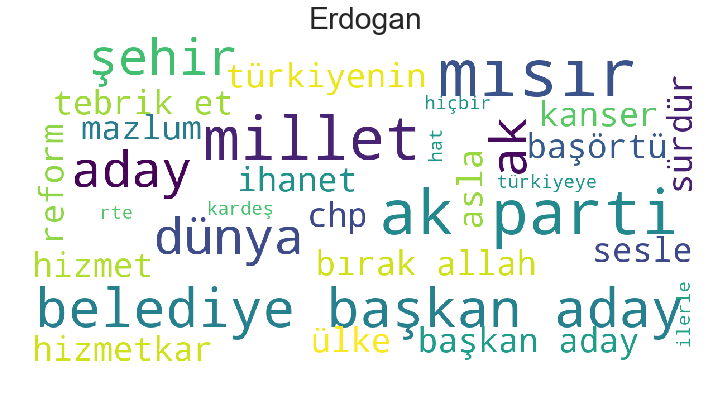

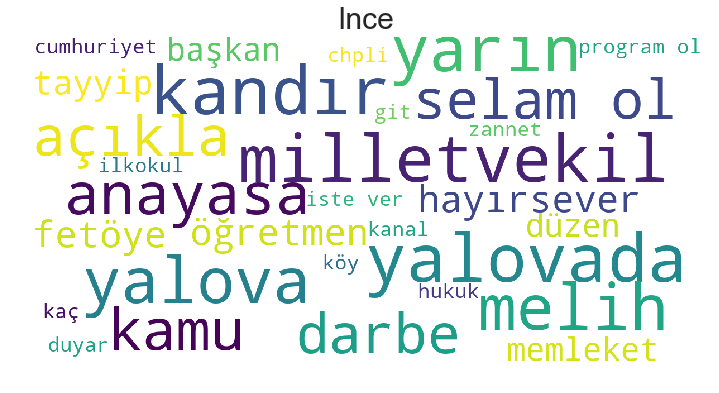

In [234]:
from wordcloud import WordCloud

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',

        max_words=30,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate_from_frequencies(data)

    fig = plt.figure(1, figsize=(12, 12))
    if title: 
        plt.title(title, fontsize=30)
    plt.axis('off')


    plt.imshow(wordcloud)
    plt.savefig('%s_wordclodud.jpg' %title)
    plt.show()
###########
show_wordcloud(bas[0], "Aksener")
show_wordcloud(bas[1],"Demirtas")
show_wordcloud(bas[2],"Erdogan")
show_wordcloud(bas[3],"Ince")

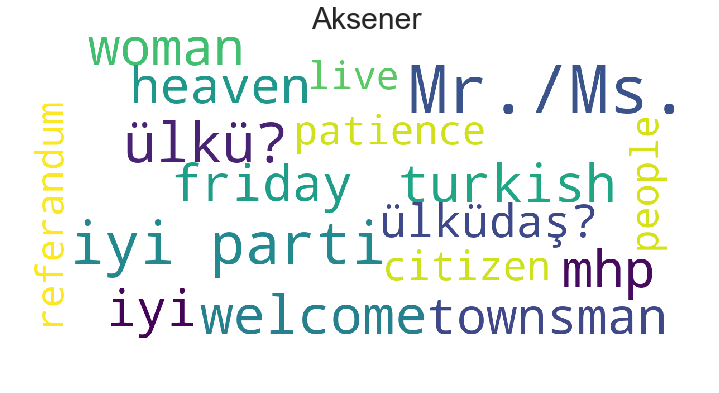

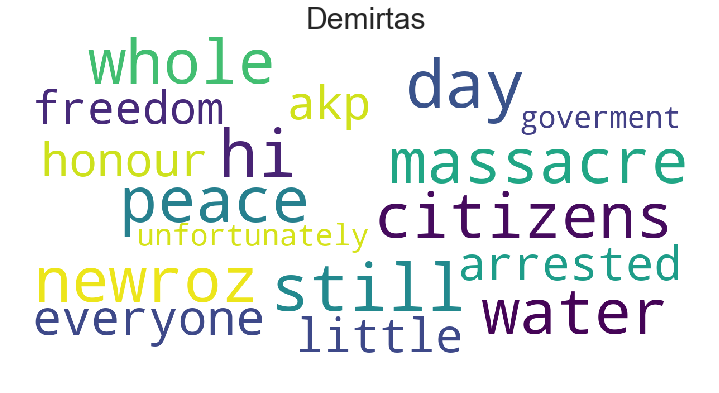

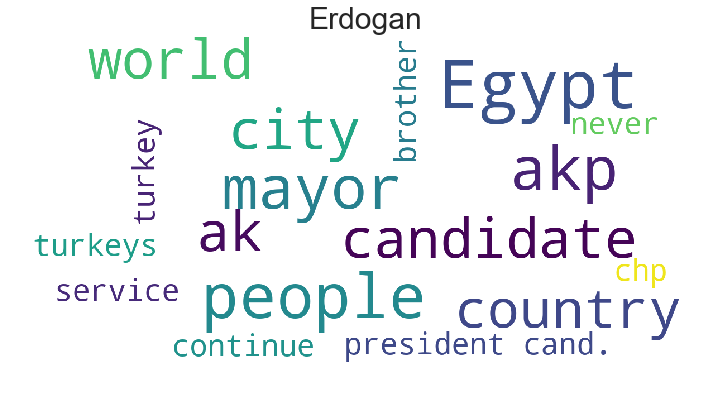

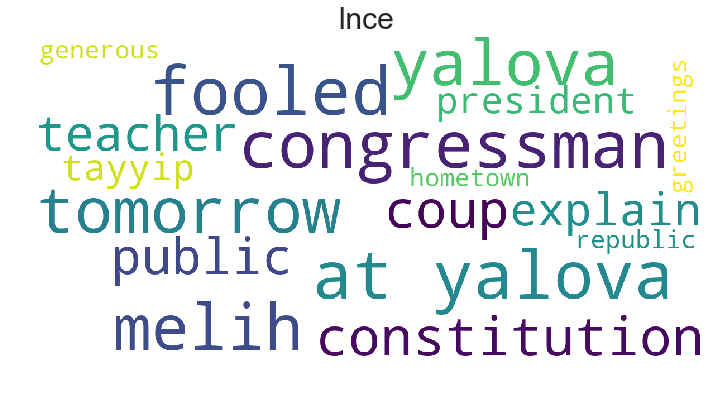

In [254]:
#english version
show_wordcloud(bas_eng_0, "Aksener")
show_wordcloud(bas_eng_1,"Demirtas")
show_wordcloud(bas_eng_2,"Erdogan")
show_wordcloud(bas_eng_3,"Ince")

Some words among these words are related to the candidates and their ideology. 
For Aksener (who is the leader of a right-mid party (with natinalist roots) called Iyi party) we can see 'ülkü' which means ideal, a word that is used by natinalists in Turkey.We can see haven and friday which are related to religion. Also Iyi parti which is her party and 'mhp' which is her old party. 

For Demirtas (who is the old leader of a left party (which is highly supported by Kurdish people)), we see newroz which is an important day celebrated by Kurdish people. Moreover  words 'arrested' and 'freedom' are related to him highly since he (some othr people from his party) are in prison at the moment. 'Peace' and 'massacre' are words that are related to events/ conflicts takes place in East of Turkey where Kurdish population is high.

For Erdogan we are not able to see as clear word representations as other candidates. We can only see 'akp' which is his party and 'continue' which is a slogan used by him during election times to maintain his party's on going governance for more than 15 years. 

'Teacher' and  'yalova' are two words that are directly related to Ince since he  is a teacher and from city of Yalova. We can see word 'coup', that is about the failed coup action done by a fraction of military in 2016. 'Fooled' is a word he uses against Erdogan frequently to critise Erdogan because of  his actions. 
In general, these words and candidate matchings seems to be appropiate. Although there is  some  noise (which is normal due the fact that the tweets are not filtered in anyway.) 

# PCA 2D

Dimesion Reduction methods are applied to visualize the tweets in 2 and 3 dimensions.

In [235]:
from sklearn.decomposition import PCA

In [236]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_train_count.toarray())
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, y_train.reset_index(drop=True)], axis = 1)

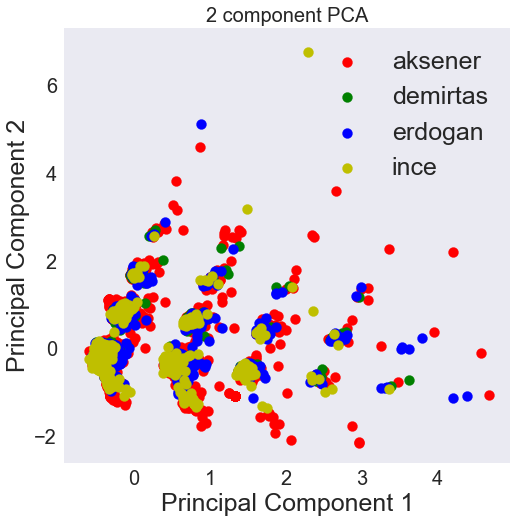

In [237]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 25)
ax.set_ylabel('Principal Component 2', fontsize = 25)
ax.set_title('2 component PCA', fontsize = 20)
targets = [ 'aksener','demirtas','erdogan', 'ince']
colors = ['r', 'g', 'b','y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['cand'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 100
              ,alpha=1)
ax.legend(targets,fontsize=25)
ax.grid()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('pca2d.jpg')
plt.show()

We can see some blobs (possible clusters) in the plot. This may potentially explained by similar words used for some discussion topics through time.

# PCA 3D

In [238]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x_train_count.toarray())
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
finalDf = pd.concat([principalDf, y_train.reset_index(drop=True)], axis = 1)

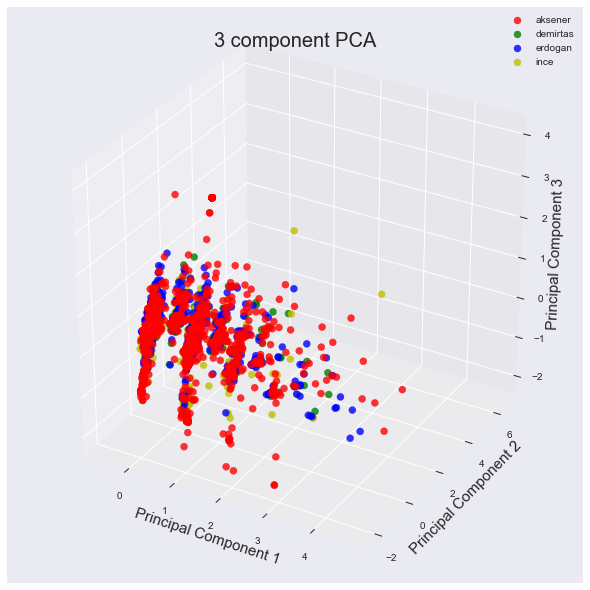

In [240]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (8,8))
ax = Axes3D(fig)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)
targets = [ 'aksener','demirtas','erdogan', 'ince']
colors = ['r', 'g', 'b','y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['cand'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , finalDf.loc[indicesToKeep, 'principal component 3']
               , c = color
               , s = 50
              ,alpha=0.8)
ax.legend(targets)
ax.grid()
plt.show()

# Linear Discriminant Analysis (LDA)

In [241]:
pca = PCA(n_components=2500)
pca_for_lda_train = pca.fit_transform(x_train_idf.toarray())

In [242]:
pca_for_lda_test=pca.transform(x_test_idf.toarray())

In [243]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components = 2)
lda_train = lda.fit_transform(pca_for_lda_train, y_train)
ldaDf = pd.DataFrame(data = lda_train
             , columns = ['1','2'])
finalDf = pd.concat([ldaDf, y_train.reset_index(drop=True)], axis = 1)

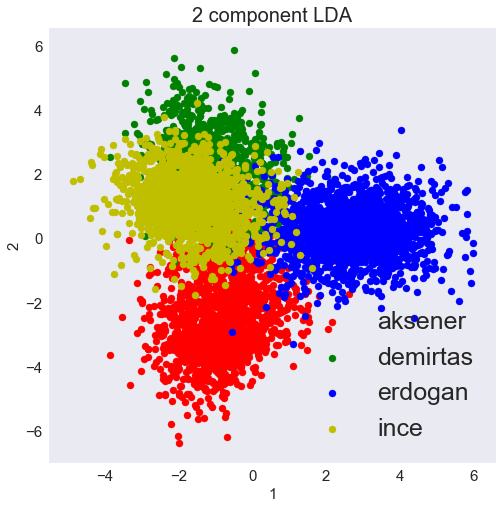

In [244]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('1', fontsize = 15)
ax.set_ylabel('2', fontsize = 15)
ax.set_title('2 component LDA', fontsize = 20)
targets = ['aksener','demirtas','erdogan', 'ince']
colors = ['r', 'g', 'b','y']
#plt.plot(lr.coef_)
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['cand'] == target
    ax.scatter(finalDf.loc[indicesToKeep, '1']
               , finalDf.loc[indicesToKeep, '2']
               , c = color
               , s = 50
              )
ax.legend(targets,fontsize=25)
ax.grid()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('lda2d.jpg')
plt.show()

In [245]:
lda_test=lda.transform(pca_for_lda_test)
lda_testDf = pd.DataFrame(data = lda_test
             , columns = ['1','2'])
final_testDf = pd.concat([lda_testDf, y_test.reset_index(drop=True)], axis = 1)

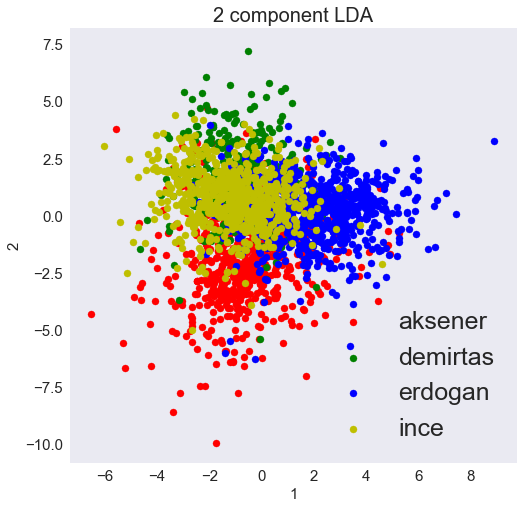

In [246]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('1', fontsize = 15)
ax.set_ylabel('2', fontsize = 15)
ax.set_title('2 component LDA', fontsize = 20)
targets = ['aksener', 'demirtas','erdogan', 'ince']
colors = ['r', 'g', 'b','y']
#plt.plot(lr.coef_)
for target, color in zip(targets,colors):
    indicesToKeep = final_testDf['cand'] == target
    ax.scatter(final_testDf.loc[indicesToKeep, '1']
               , final_testDf.loc[indicesToKeep, '2']
               , c = color
               , s = 50
              )
ax.legend(targets,fontsize=25)
ax.grid()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('lda2d_test.jpg')
plt.show()

# Important words W2V + PCA

Visualizing important words(features) and to be able detect possible gatheings of similar words is the final tassk we worked on. In order to do this, each important word is represented in a feature space of 400 dimension using Word2Vec. After this transformation, their dimension is reduced to 2 and 3 using PCA in order to vosualize it.

In [284]:
all_words=list(bas[0].keys())+list(bas[1].keys())+list(bas[2].keys())+list(bas[3].keys())
all_words=[w for w in all_words if len(w.split())==1]

In [285]:
X=[]
stops=[]
for w in all_words:
    try:
        X.append(word_vectors[w])
    except:
        stops.append(w)
        continue
#X=word_vectors[all_words]
for rw in stops:
    all_words.remove(rw)
pca = PCA(n_components=3)
pc = pca.fit_transform(X)
df = pd.DataFrame(data = pc
             , columns = ['1', '2','3'],index=all_words)

In [286]:
df['cand']=None
def cand_finder(w):
    if w in bas[0]:
        return('aksener')
    if w in bas[1]:
        return('demirtas')
    if w in bas[2]:
        return('erdogan')
    if w in bas[3]:
        return('ince')
df['cand']=df.index.map(cand_finder)

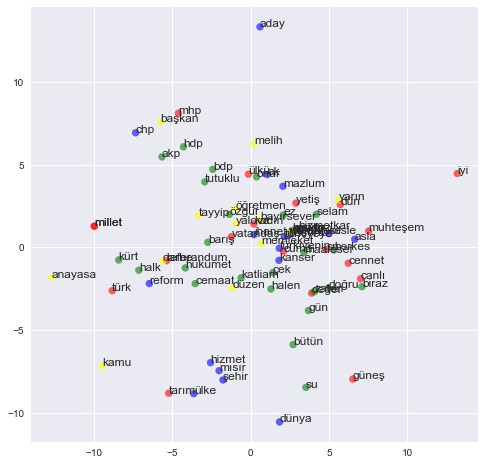

In [287]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
#fig.figure()
ax = fig.add_subplot(1, 1, 1)
color_dict = { 'demirtas':'green', 'erdogan':'blue', 'aksener':'red', 'ince':'yellow' }
c=[color_dict[i] for i in df['cand']]

ax.scatter(df['1'], df['2'],c=c,alpha=0.6)
for w, p in df.iterrows():
    ax.annotate(w,(p[0],p[1]))
    
#plt.savefig('word_map_all.jpg')
plt.show()

In this plot, we are able to see the most important features(words) of the model with the best accuracy score represented in 2D. We can see that we have some groups of words where the context of the words are similar however we still observe many words that are plotted close but has low relation. This is due to the reasons we have mentioned in the upper part about the word2vec model. In addition to that, we may have not achieved the meaningful representation due to reducing the dimension from 400 to 2 using PCA.